# Breast Cancer Prediction

In this exercise, you will train a neural network on the [Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)) to predict if the tumor is malignant or benign.

If you get stuck, we recommend that you review the ungraded labs for this week.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

## Load and Preprocess the Dataset

We first download the dataset and create a data frame using pandas. We explicitly specify the column names because the CSV file does not have column headers.

In [2]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

24576/19889 [=====================================] - 0s 3us/step


In [3]:
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


We have to do some preprocessing on the data. We first pop the id column since it is of no use for our problem at hand.

In [4]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

Upon inspection of data, you can see that some values of the **bare_nuclei** column are unknown. We drop the rows with these unknown values. We also convert the **bare_nuclei** column to numeric. This is required for training the model.

In [5]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

We check the class distribution of the data. You can see that there are two classes, 2.0 and 4.0
According to the dataset:
* **2.0 = benign**
* **4.0 = malignant**


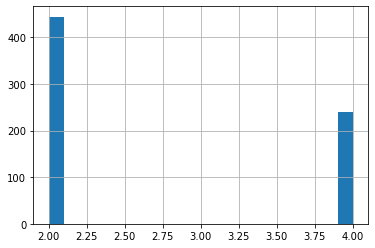

In [6]:
df['class'].hist(bins=20) 

We are going to model this problem as a binary classification problem which detects whether the tumor is malignant or not. Hence, we change the dataset so that:
* **benign(2.0) = 0**
* **malignant(4.0) = 1**

In [7]:
df['class'] = np.where(df['class'] == 2, 0, 1)

We then split the dataset into training and testing sets. Since the number of samples is small, we will perform validation on the test set.

In [8]:
train, test = train_test_split(df, test_size = 0.2)

We get the statistics for training. We can look at statistics to get an idea about the distribution of plots. If you need more visualization, you can create additional data plots. We will also be using the mean and standard deviation from statistics for normalizing the data

In [9]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

We pop the class column from the training and test sets to create train and test outputs.

In [10]:
train_Y = train.pop("class")
test_Y = test.pop("class")

Here we normalize the data by using the formula: **X = (X - mean(X)) / StandardDeviation(X)**

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [12]:
norm_train_X = norm(train)
norm_test_X = norm(test)

We now create Tensorflow datasets for training and test sets to easily be able to build and manage an input pipeline for our model.

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

We shuffle and prepare a batched dataset to be used for training in our custom training loop.

In [14]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [15]:
a = enumerate(train_dataset)

print(len(list(a)))

18


## Define the Model

Now we will define the model. Here, we use the Keras Functional API to create a simple network of two `Dense` layers. We have modelled the problem as a binary classification problem and hence we add a single layer with sigmoid activation as the final layer of the model.

In [16]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

## Define Optimizer and Loss

We use RMSprop optimizer and binary crossentropy as our loss function.

In [17]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Evaluate Untrained Model
We calculate the loss on the model before training begins.

In [18]:
outputs = model(norm_test_X.values)
loss_value = loss_object(y_true=test_Y.values, y_pred=outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.7123


We also plot the confusion matrix to visualize the true outputs against the outputs predicted by the model.

In [19]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

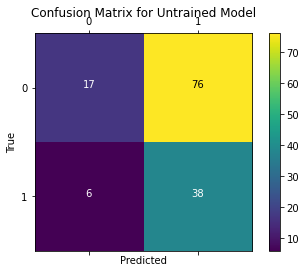

In [20]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

## Define Metrics (Please complete this section)

### Define Custom F1Score Metric
In this example, we will define a custom F1Score metric using the formula. 

**F1 Score = 2 * ((precision * recall) / (precision + recall))**

**precision = true_positives / (true_positives + false_positives)**

**recall = true_positives / (true_positives + false_negatives)**

We use `confusion_matrix` defined in `tf.math` to calculate precision and recall.

Here you can see that we have subclassed `tf.keras.Metric` and implemented the three required methods `update_state`, `result` and `reset_states`.

### Please complete the result() method:

In [21]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''
        
        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric
        
        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        
        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
      
        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        ### START CODE HERE ###
        f1_score = 2 * ((precision * recall) / (precision + recall))
        ### END CODE HERE ###
        
        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''
        
        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0) 
        self.fp.assign(0)
        self.fn.assign(0)


In [22]:
# Test Code:

test_F1Score = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()


<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

**Expected Output:**

```txt
<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>
```